# Data experiments

## Abundance of ants

Load `gmf` library and set meta variables for displaying plots.

In [ ]:
install.packages('gmf', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('raster', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('mvabund', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('gllvm', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('ggplot2', dependencies=TRUE, repos='https://CRAN.R-project.org/')

In [ ]:
install.packages('gmf', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('raster', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('mvabund', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('gllvm', dependencies=TRUE, repos='https://CRAN.R-project.org/')
install.packages('ggplot2', dependencies=TRUE, repos='https://CRAN.R-project.org/')

In [2]:
# library("devtools") ; install(".",upgrade = FALSE)
# library("gmf")
library(raster) 
library(mvabund)
library(gllvm)
library(ggplot2)
theme_set(theme_minimal(base_size = 15)) # choose a theme and large font for presentation clarity
options(repr.plot.width=4, repr.plot.height=4) # set the size of the plots

ERROR: Error in library(raster): there is no package called ‘raster’


## Load data

Load ants' data.

In [2]:
data(antTraits)
Y = as.matrix(antTraits$abund)
X = as.matrix(antTraits$env)
X = X[,-3,drop=FALSE]
d = 2 # we choose 2 latent dimensions
names(antTraits$env)
fm = poisson()

[1] "Bare.ground"       "Canopy.cover"      "Shrub.cover"      
[4] "Volume.lying.CWD"  "Feral.mammal.dung"

Fit models the models: GLLVM, Newton, AIRWLS.

In [3]:
options(warn = -1) 

tol = 1e-3

ptm <- proc.time()
model.gmf.newton = gmf.newton(Y = Y, X = X, d = d,
                              gamma=0.1, maxIter = 100,
                              family = fm,
                              method = "quasi",
                              tol = tol)
time.gmf.newton = proc.time() - ptm

ptm <- proc.time()
#  X = X, 
model.gmf.airwls = gmf.newton(Y = Y, X = X, d = d,
                                gamma=0.1, maxIter = 10,
                                family = fm, 
                                parallel = 1,
                                method = "airwls",
                                tol = tol)
time.gmf.airwls = proc.time() - ptm

ptm <- proc.time()
model.gllvm = gllvm(y = Y,
                    X = X,
                    formula = ~ . - 1,
                    family=fm$family,
                    num.lv = d,
                   reltol = tol)
time.gllvm = proc.time() - ptm

M.gllvm = residuals(model.gllvm)$linpred
M.gmf.newton = model.gmf.newton$fit
M.gmf.airwls = model.gmf.airwls$fit

results = data.frame(gllvm = c(M.gllvm), 
                     pca = c(M.gmf.newton),
                     nuc = c(M.gmf.airwls))

iteration 10 loss = 0.003369623 
iteration 20 loss = 0.00325635 
[1] "Stopped after 29 iterations with deviance 0.00321791365873077"
iteration 10 loss = 0.002805441 
[1] "Stopped after 10 iterations with deviance 0.00280544132131851"


Show predictions from three models.

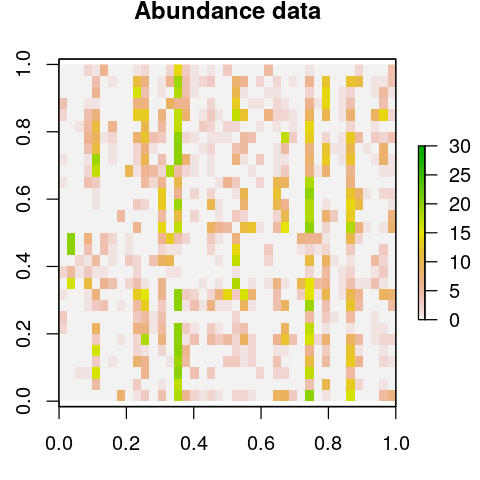

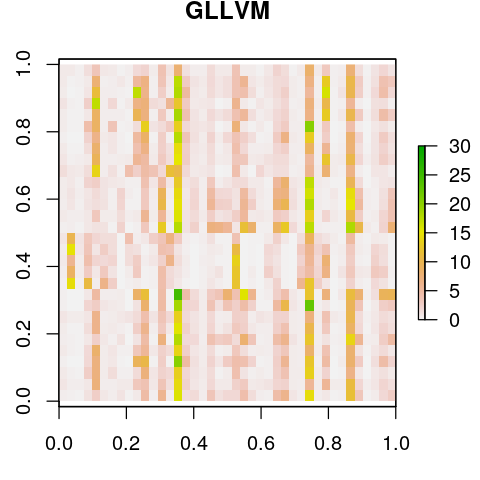

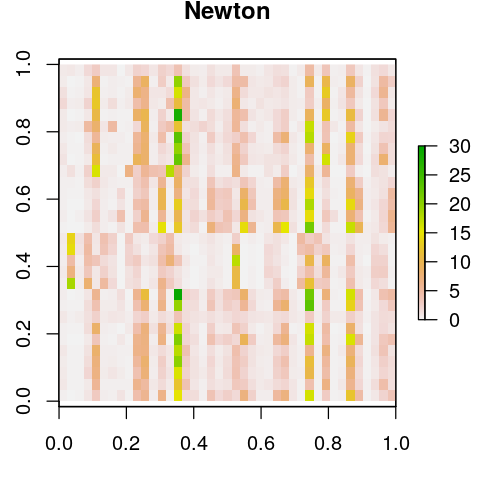

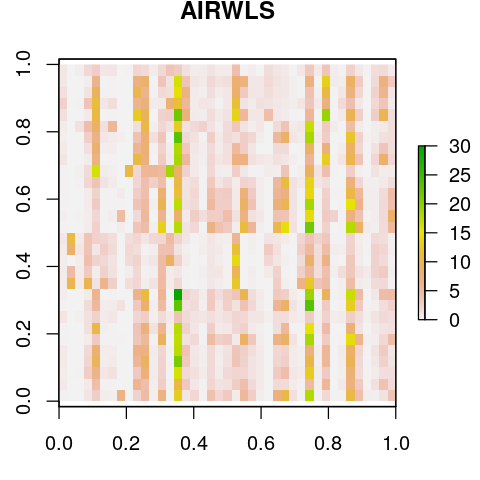

In [4]:
options(repr.plot.width=4, repr.plot.height=4)
cuts=c(0,5,10,15,20,25,30)
plot(raster(Y),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("Abundance data")
plot(raster(exp(M.gllvm)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("GLLVM")
plot(raster(exp(M.gmf.newton)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("Newton")
plot(raster(exp(M.gmf.airwls)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("AIRWLS")

In [5]:
#cat("Correlation between GLLVM and Newton:   ",cor(c(M.gmf.newton),c(M.gllvm)))
cat("\nCorrelation between GLLVM and alt glmm: ",cor(c(M.gmf.airwls),c(M.gllvm)))
cat("\nTime gllvm:",time.gllvm[1],"seconds")
cat("\nTime Newton:",time.gmf.newton[1],"seconds")
cat("\nTime alt:",time.gmf.airwls[1],"seconds")


Correlation between GLLVM and alt glmm:  0.4416937
Time gllvm: 1.681 seconds
Time Newton: 0.06 seconds
Time alt: 1.346 seconds

In [6]:
fm = poisson()
print(gmf.deviance(pred = fm$linkinv(M.gmf.airwls), obs = Y, family = fm))
print(gmf.deviance(pred = fm$linkinv(M.gmf.newton), obs = Y, family = fm))
print(gmf.deviance(pred = fm$linkinv(M.gllvm), obs = Y, family = fm))

print(summary(c(M.gmf.airwls)))
print(summary(c(M.gmf.newton)))
print(summary(c(M.gllvm)))

[1] 1.561354
[1] 1.713541
[1] 1.820097
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-237.8524   -1.7446   -0.1513   -3.4406    1.0430    3.3839 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-13.87609  -1.15824  -0.07256  -0.13626   1.08699   3.38668 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-7.9036 -1.0598 -0.1703 -0.1351  1.0220  3.2133 


[1] -0.4799181

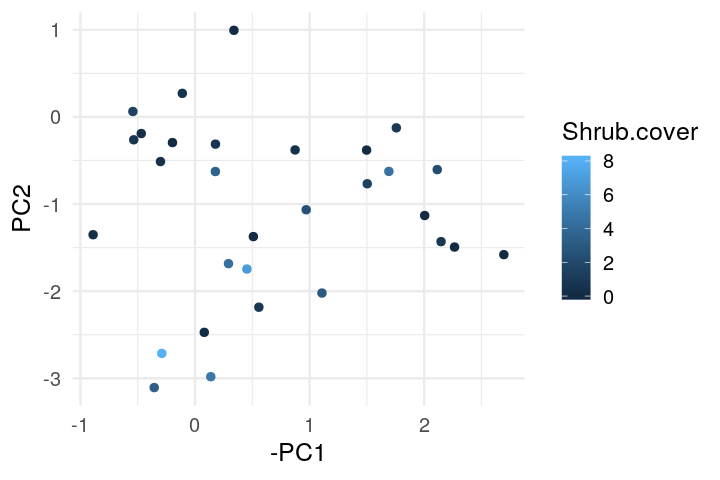

In [7]:
U= model.gmf.airwls$u
colnames(U) = c("PC1","PC2")
rownames(U) = paste("Site",rownames(antTraits$env))
U = data.frame(U)
U$Shrub.cover = antTraits$env[,3]

options(repr.plot.width=6, repr.plot.height=4)
p<-ggplot(U,aes(x=-PC1,y=PC2,color=Shrub.cover,label=row.names(U) ))
p<-p+geom_point(size=2) #+ geom_text(size=4,nudge_y = 0.06)
p

cor(U$Shrub.cover,U$PC2)

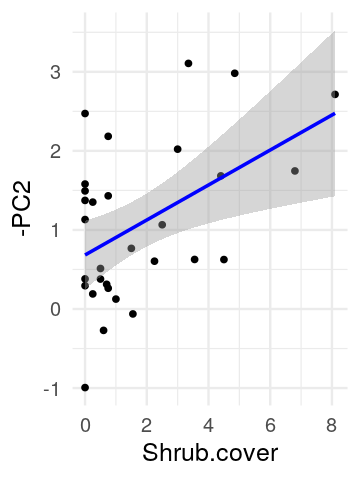

In [8]:
options(repr.plot.width=3, repr.plot.height=4)
ggplot(U, aes(y = -PC2, x = Shrub.cover)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "blue")

## Youth gratitude
# Load data

In [67]:
#install.packages("psychotools")
library(psychotools)
data("YouthGratitude")
X = YouthGratitude[,2,drop=FALSE]
Y = YouthGratitude[,-(1:3)]
X = as.matrix(X[1:300,,drop=FALSE])
Y = as.matrix(Y[1:300,,drop=FALSE])
d=2
fm = gaussian()

Fit models the models: GLLVM, Newton, ALS.

In [74]:
options(warn = -1) 

tol = 1e-3

ptm <- proc.time()
model.gmf.newton = gmf.newton(Y = Y, d = d,
                              gamma=0.1, maxIter = 100,
                              family = fm,
                              method = "quasi",
                              tol = tol)
time.gmf.newton = proc.time() - ptm

ptm <- proc.time()
#  X = X, 
model.gmf.airwls = gmf.newton(Y = Y, d = d,
                                gamma=0.1, maxIter = 10,
                                family = fm, 
                                parallel = 1,
                                method = "airwls",
                                tol = tol)
time.gmf.airwls = proc.time() - ptm

ptm <- proc.time()
model.gllvm = gllvm(y = Y,
                    formula = ~ . - 1,
                    family=fm$family,
                    num.lv = d,
                   reltol = tol)
time.gllvm = proc.time() - ptm

M.gllvm = residuals(model.gllvm)$linpred
M.gmf.newton = model.gmf.newton$fit
M.gmf.airwls = model.gmf.airwls$fit

results = data.frame(gllvm = c(M.gllvm), 
                     pca = c(M.gmf.newton),
                     nuc = c(M.gmf.airwls))

iteration 10 loss = 0.002719349 
[1] "Stopped after 15 iterations with deviance 0.00268721962607616"
iteration 10 loss = 0.001290104 
[1] "Stopped after 10 iterations with deviance 0.00129010401739891"


Show predictions from three models.

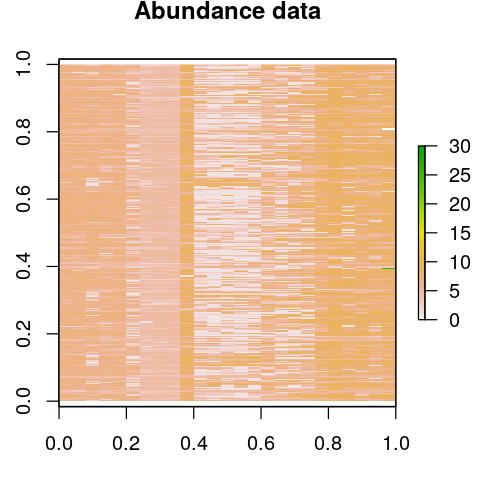

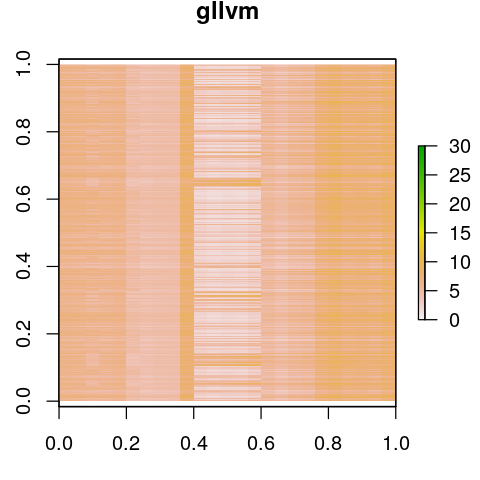

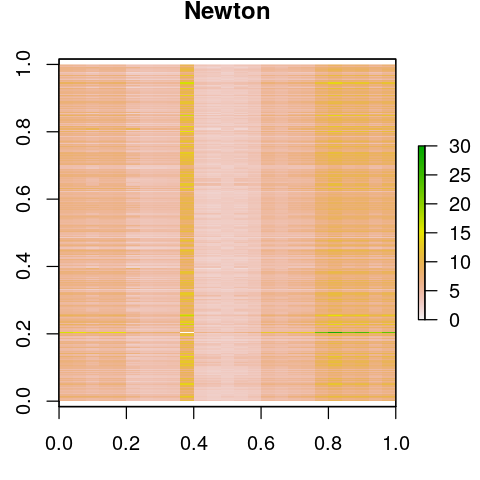

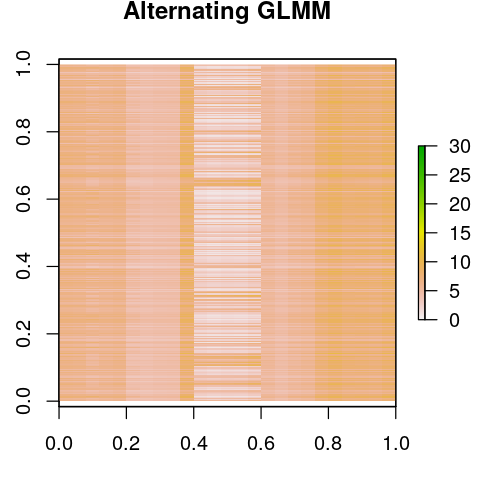

In [75]:
options(repr.plot.width=4, repr.plot.height=4)
cuts=c(0,5,10,15,20,25,30)
plot(raster(Y),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("Abundance data")
plot(raster(exp(M.gllvm)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("gllvm")
plot(raster(exp(M.gmf.newton)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("Newton")
plot(raster(exp(M.gmf.airwls)),lab.breaks=cuts,zlim=c(0,max(cuts)))
title("Alternating GLMM")

In [76]:
#cat("Correlation between GLLVM and Newton:   ",cor(c(M.gmf.newton),c(M.gllvm)))
cat("\nCorrelation between GLLVM and alt glmm: ",cor(c(M.gmf.airwls),c(M.gllvm)))
cat("\nTime gllvm:",time.gllvm[1],"seconds")
cat("\nTime Newton:",time.gmf.newton[1],"seconds")
cat("\nTime alt:",time.gmf.airwls[1],"seconds")


Correlation between GLLVM and alt glmm:  0.9770074
Time gllvm: 10.11 seconds
Time Newton: 0.049 seconds
Time alt: 4.256 seconds

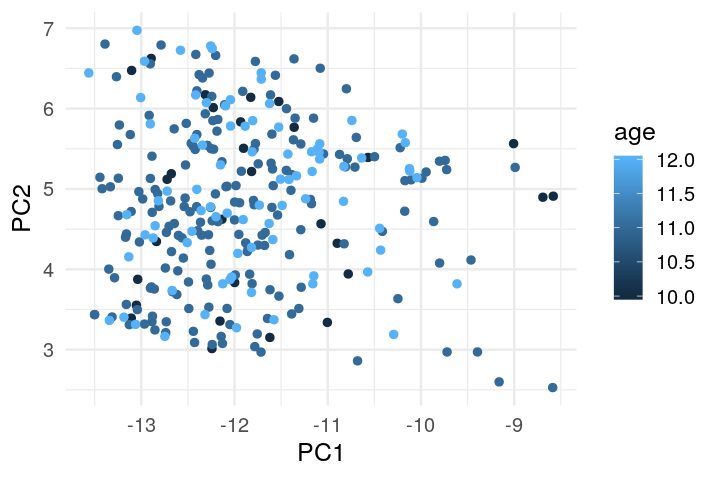

In [77]:
U = model.gmf.airwls$u
colnames(U) = c("PC1","PC2")
U=data.frame(U)
U$age = X

options(repr.plot.width=6, repr.plot.height=4)
p<-ggplot(data.frame(U),aes(x=PC1,y=PC2,color=age))
p<-p+geom_point(size=2) #+ geom_text(size=4,nudge_y = 0.06)
p

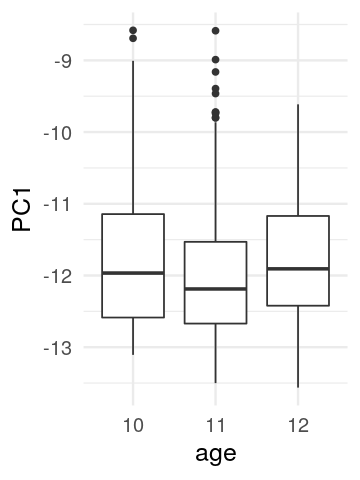

In [78]:
options(repr.plot.width=3, repr.plot.height=4)
U$age = factor(U$age)
ggplot(U, aes(y = PC1, x = age)) + 
  geom_boxplot() +
  stat_smooth(method = "lm", col = "blue")

Warning message in log(y/mu):
“NaNs produced”


[1] 0.0166005

Warning message in log(y/mu):
“NaNs produced”


[1] 6.307699

[1] 6.244411

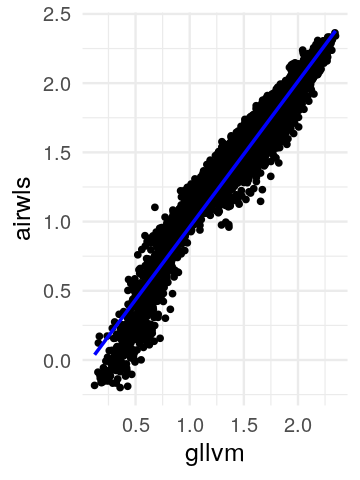

In [79]:
gmf.deviance(c(M.gmf.airwls),c(M.gllvm),family = poisson())
gmf.deviance(c(M.gmf.airwls),c(Y),family = poisson())
gmf.deviance(c(M.gllvm),c(Y),family = poisson())

similarity = data.frame(airwls = c(M.gmf.airwls), gllvm = c(M.gllvm))
ggplot(similarity, aes(x = gllvm, y = airwls)) + 
  geom_point() +
  stat_smooth(method = "lm", col = "blue")